In [567]:
import sys
#sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
from numpy import inf
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc
from tqdm import tqdm_notebook, tqdm 
import matplotlib.pyplot as plt
import datetime
import json
from scipy import stats

In [57]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
mapping = pd.read_csv('./data/building_metadata.csv')
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')

In [58]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [59]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [60]:
del weather_train 
del weather_test

In [61]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [80]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [64]:
df_train.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


In [65]:
# Check one building
df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [ ]:
df_train_build.head(20)

In [67]:
### Intrapolate cloud coverage
df_train['cloud_coverage'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['cloud_coverage'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [68]:
### Intrapolate air temperature
df_train['air_temperature'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['air_temperature'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [62]:
### Lags for cloud coverage and air temperature
for i in range(5):
    df_train[f'cloud_coverage_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
    df_test[f'cloud_coverage_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
    df_train[f'air_temperature_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)
    df_test[f'air_temperature_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)

In [ ]:
df_train.dtypes

In [15]:
#### Take a Sample ####
#df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=1)
#df_test = df_test.sample(n=int(df_test.shape[0]*0.1), random_state=1)

In [16]:
#df_train["Month"] = pd.to_datetime(df_train["timestamp"]).dt.month
#df_test["Month"] = pd.to_datetime(df_test["timestamp"]).dt.month

In [69]:
df_train["Day"] = pd.to_datetime(df_train["timestamp"]).dt.day
df_test["Day"] = pd.to_datetime(df_test["timestamp"]).dt.day

In [70]:
df_train["Hour"] = pd.to_datetime(df_train["timestamp"]).dt.hour
df_test["Hour"] = pd.to_datetime(df_test["timestamp"]).dt.hour

In [87]:
df_train.to_csv("df_train.csv", index = False)
df_test.to_csv("df_test.csv", index = False)

In [84]:
df_train = pd.read_csv('./df_train.csv')
df_test = pd.read_csv('./df_test.csv')

In [85]:
df_train["DayOfWeek"] = pd.to_datetime(df_train["timestamp"]).dt.dayofweek
df_test["DayOfWeek"] = pd.to_datetime(df_test["timestamp"]).dt.dayofweek

In [19]:
#df_train = dp.create_stats_features(df_train, 'dew_temperature', ['site_id', 'Month'])
#df_test = dp.create_stats_features(df_test, 'dew_temperature', ['site_id', 'Month'])

In [20]:
#df_train["air_temperature_log"] = np.log(df_train['air_temperature'])
#df_test["air_temperature_log"] = np.log(df_test['air_temperature'])

In [21]:
#df_train["Age"] = pd.to_datetime(df_train["timestamp"]).dt.year - df_train["year_built"]
#df_test["Age"] = pd.to_datetime(df_test["timestamp"]).dt.year - df_test["year_built"]

In [710]:
### Clean Electricity ###
df_train = df_train[~((df_train['site_id'] == 0) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-20 18:00:00')))]

In [719]:
df_train_elec = df_train[(df_train['site_id'] == 6) & (df_train['meter'] == 1)] 
df_train_elec_test = df_train_elec[df_train_elec['building_id'] == 753]

In [732]:
#test = df_train_elec.groupby('building_id', as_index=True)['meter_reading'].apply(lambda x: x[x < x.quantile(0.99)]).reset_index().drop(['level_1'], axis = 1)
df_train_elec_test[(np.abs(stats.zscore(df_train_elec_test['meter_reading'])) < 5)]

(8732, 19)

In [716]:
df_train_elec = df_train[(df_train['meter'] == 1) & (df_train['building_id'] == 753)] 

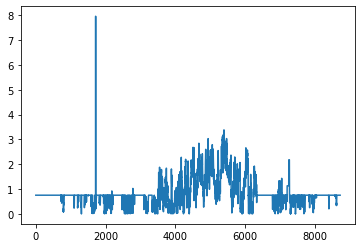

In [718]:
z = np.abs(stats.zscore(df_train_elec['meter_reading']))
plt.plot(z)

In [586]:
#df_train_elec.head()

In [587]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-05-20 17:00:00')].head(30) 

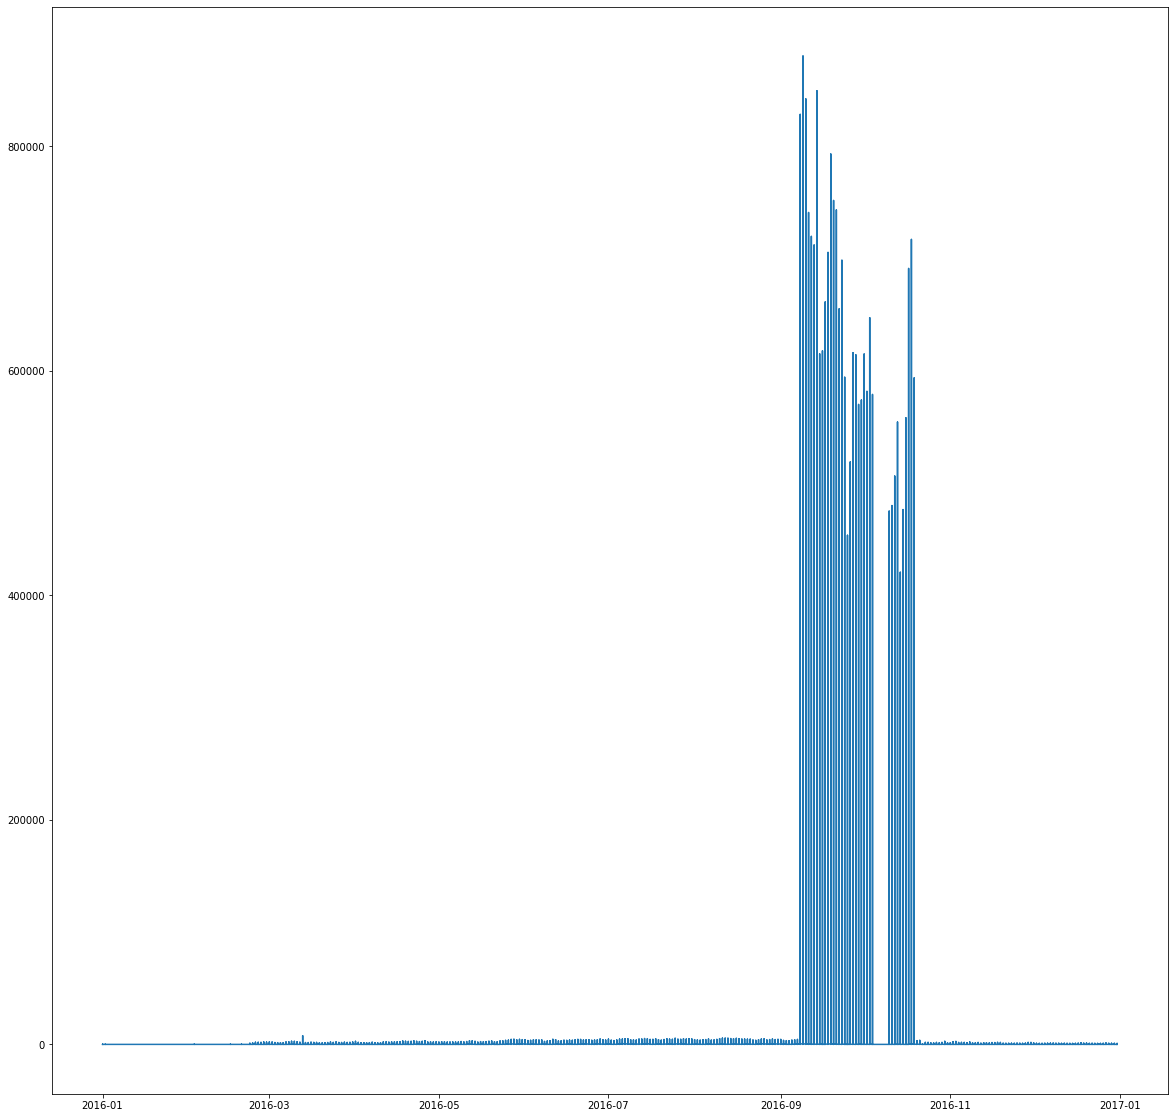

In [711]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(df_train_elec["timestamp"]).dt.date, df_train_elec['meter_reading'])

In [230]:
#df_train = df_train[df_train["meter_reading"] != 0.0]

In [10]:
#encode_cols = ["primary_use"]

In [11]:
#data = dp.encode_categorical(df_train, df_test, encode_cols) 

colums primary_use is being encoded


In [12]:
#mb = mc.modelBuilder('regression', 'LGBM')

In [99]:
#data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                             target = 'meter_reading', rem_cols = ['timestamp'], 
#                             useVarImp = False, varimp_threshold = 100)

17 features have been chosen for modeling


In [100]:
#data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)

In [101]:
#data['Y'] = np.log(data['Y'])

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [102]:
#data['Y'][data['Y'] == -inf] = 0

In [1]:
#data['Y'].describe()

NameError: name 'data' is not defined

In [522]:
def rmse(y, yhat):
    score = sqrt(mean_squared_error(y, yhat))
    return(score)

In [733]:
# LGBM
params = {
    'boosting_type':'gbdt',
    'n_estimators':500,
    'num_leaves':64, 
    'objective':'regression_l2', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.3,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'rmse', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':1234,
    'lambda_l2': 1.5,
    'verbose' : 2,
    #'reg_alpha':0.0,
    #'reg_lambda':0.0, 
    #'silent':True, 
    'subsample':1.0
    #,
    #'early_stopping_round' : 100
}

In [66]:
#gc.collect()

In [67]:
#df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [68]:
#df_train_build.head(20)

In [69]:
#submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                      save_varimp = True, params = params, oversmp = False, cv_shuffle=False)

In [737]:
### Per site and meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(6, 7, 1)):
    print(f'training site_id {i}')
    
    df_train_site = df_train[df_train['site_id'] == i]
    df_test_site = df_test[df_test['site_id'] == i]
    
    for j in df_train_site['meter'].unique():
        
        print(f'training meter {j}')
        df_train_metr = df_train_site[df_train_site['meter'] == j]
        df_test_metr = df_test_site[df_test_site['meter'] == j]

        df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
        
        data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
        data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp'], 
                                 useVarImp = False, varimp_threshold = 100)
        data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
        data['Y'] = np.log(data['Y'])
        data['Y'][data['Y'] == -inf] = 0
        submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
        submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
        final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

        perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
        final_sub_lst.append(final_submit)
    

training site_id 1
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5502269106064527
Fold: 1
The valuation metric for the fold 1 is 0.6122029515963936
Fold: 2
The valuation metric for the fold 2 is 0.812811715185831
Fold: 3
The valuation metric for the fold 3 is 0.466182228003455
Fold: 4
The valuation metric for the fold 4 is 1.4481409518579804
The average score accross the folds is 0.7779129514500226
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.4388279993360569
Fold: 1
The valuation metric for the fold 1 is 1.4701752864388342
Fold: 2
The valuation metric for the fold 2 is 1.6502518928982914
Fold: 3
The valuation metric for the fold 3 is 1.7639552985142188
Fold: 4
The valuation metric for the fold 4 is 2.272485406366511
The average score accross the folds is 1.7191391767107824
training site_id 2
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 0.5670523282878857
Fold: 1
The valuation metric for the fold 1 is 0.480314083216345
Fold: 2
The valuation metric for the fold 2 is 0.5747377154650617
Fold: 3
The valuation metric for the fold 3 is 0.5009661798667692
Fold: 4
The valuation metric for the fold 4 is 0.6505947895808412
The average score accross the folds is 0.5547330192833806
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 1.464288520157907
Fold: 1
The valuation metric for the fold 1 is 1.1453938643218706
Fold: 2
The valuation metric for the fold 2 is 1.1440542728197518
Fold: 3
The valuation metric for the fold 3 is 1.1507443379914584
Fold: 4
The valuation metric for the fold 4 is 1.412499607015665
The average score accross the folds is 1.2633961204613304
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.3540926122512738
Fold: 1
The valuation metric for the fold 1 is 0.9715449821389003
Fold: 2
The valuation metric for the fold 2 is 0.77581911570824
Fold: 3
The valuation metric for the fold 3 is 0.8849947860642178
Fold: 4
The valuation metric for the fold 4 is 1.2417783122954509
The average score accross the folds is 1.0456459616916165
training site_id 3
training meter 0
colums primary_use is being encoded
17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 0.5685067906686276
Fold: 1
The valuation metric for the fold 1 is 0.5071124186902388
Fold: 2
The valuation metric for the fold 2 is 0.44231922589528067
Fold: 3
The valuation metric for the fold 3 is 0.4348504081324336
Fold: 4
The valuation metric for the fold 4 is 0.5624524508300426
The average score accross the folds is 0.5030482588433246
training site_id 4
training meter 0
colums primary_use is being encoded
17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 0.27160870240281637
Fold: 1
The valuation metric for the fold 1 is 0.24143963653196793
Fold: 2
The valuation metric for the fold 2 is 0.29767628814249225
Fold: 3
The valuation metric for the fold 3 is 0.22634949786280978
Fold: 4
The valuation metric for the fold 4 is 0.2871353810908724
The average score accross the folds is 0.2648419012061917
training site_id 5
training meter 0
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.9689468119033553
Fold: 1
The valuation metric for the fold 1 is 0.9150797205657402
Fold: 2
The valuation metric for the fold 2 is 0.9986201112741622
Fold: 3
The valuation metric for the fold 3 is 0.9761290942682146
Fold: 4
The valuation metric for the fold 4 is 1.1250886877565913
The average score accross the folds is 0.9967728851536126
training site_id 6
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3199650221422316
Fold: 1
The valuation metric for the fold 1 is 0.26963446252111295
Fold: 2
The valuation metric for the fold 2 is 0.30897316361020644
Fold: 3
The valuation metric for the fold 3 is 0.33140545760323037
Fold: 4
The valuation metric for the fold 4 is 0.3686316372749935
The average score accross the folds is 0.31972194863035497
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.535073729197186
Fold: 1
The valuation metric for the fold 1 is 1.7433884916075215
Fold: 2
The valuation metric for the fold 2 is 1.2374942288318873
Fold: 3
The valuation metric for the fold 3 is 1.5843223118691347
Fold: 4
The valuation metric for the fold 4 is 2.1353746468611967
The average score accross the folds is 1.847130681673385
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.5537591340153085
Fold: 1
The valuation metric for the fold 1 is 1.6842357407523592
Fold: 2
The valuation metric for the fold 2 is 1.3545061072859061
Fold: 3
The valuation metric for the fold 3 is 1.9292960717891032
Fold: 4
The valuation metric for the fold 4 is 1.725961246504206
The average score accross the folds is 1.6495516600693765
training site_id 7
training meter 1
colums primary_use is being encoded
17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 1.1280284688648539
Fold: 1
The valuation metric for the fold 1 is 1.7181459559774277
Fold: 2
The valuation metric for the fold 2 is 1.6477922137268415
Fold: 3
The valuation metric for the fold 3 is 1.8600069017406844
Fold: 4
The valuation metric for the fold 4 is 1.4270832157409088
The average score accross the folds is 1.5562113512101434
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.4718999863652633
Fold: 1
The valuation metric for the fold 1 is 2.1442567964573667
Fold: 2
The valuation metric for the fold 2 is 1.6280298744418173
Fold: 3
The valuation metric for the fold 3 is 1.9192351110927297
Fold: 4
The valuation metric for the fold 4 is 1.833258268373717
The average score accross the folds is 1.7993360073461786
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 3.1318762334981223
Fold: 1
The valuation metric for the fold 1 is 2.756420258485205
Fold: 2
The valuation metric for the fold 2 is 2.0952076364696084
Fold: 3
The valuation metric for the fold 3 is 2.4394226985968657
Fold: 4
The valuation metric for the fold 4 is 3.6596425912034594
The average score accross the folds is 2.8165138836506523
training meter 3
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.6890365819651088
Fold: 1
The valuation metric for the fold 1 is 2.7543065561480637
Fold: 2
The valuation metric for the fold 2 is 2.6632751786293634
Fold: 3
The valuation metric for the fold 3 is 2.728775524517004
Fold: 4
The valuation metric for the fold 4 is 1.7783804974472661
The average score accross the folds is 2.122754867741361
training site_id 8
training meter 0
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.7436116467241424
Fold: 1
The valuation metric for the fold 1 is 0.7204699440351978
Fold: 2
The valuation metric for the fold 2 is 0.7383265004157774
Fold: 3
The valuation metric for the fold 3 is 0.7296969992278408
Fold: 4
The valuation metric for the fold 4 is 0.7590099890269844
The average score accross the folds is 0.7382230158859887
training site_id 9
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 1.2077582711316892
Fold: 1
The valuation metric for the fold 1 is 0.9100685369837885
Fold: 2
The valuation metric for the fold 2 is 1.3162368294521511
Fold: 3
The valuation metric for the fold 3 is 1.178605064489692
Fold: 4
The valuation metric for the fold 4 is 0.8959714662368929
The average score accross the folds is 1.1017280336588429
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 1.4010852795282347
Fold: 1
The valuation metric for the fold 1 is 1.312623178158527
Fold: 2
The valuation metric for the fold 2 is 1.6735692540557816
Fold: 3
The valuation metric for the fold 3 is 1.4678775759365466
Fold: 4
The valuation metric for the fold 4 is 1.2889419222260186
The average score accross the folds is 1.4288194419810216
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.513578066722856
Fold: 1
The valuation metric for the fold 1 is 1.3741059032503185
Fold: 2
The valuation metric for the fold 2 is 1.6489072683639416
Fold: 3
The valuation metric for the fold 3 is 1.5508770544851902
Fold: 4
The valuation metric for the fold 4 is 1.3816645066768265
The average score accross the folds is 1.4938265598998268
training site_id 10
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.4463015978096239
Fold: 1
The valuation metric for the fold 1 is 0.4390065447796008
Fold: 2
The valuation metric for the fold 2 is 0.4546511583970337
Fold: 3
The valuation metric for the fold 3 is 0.41491922479874305
Fold: 4
The valuation metric for the fold 4 is 0.579728917919631
The average score accross the folds is 0.4669214887409264
training meter 1
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.98823472014587
Fold: 1
The valuation metric for the fold 1 is 1.9886781947055854
Fold: 2
The valuation metric for the fold 2 is 1.652336032101733
Fold: 3
The valuation metric for the fold 3 is 1.7150030459232102
Fold: 4
The valuation metric for the fold 4 is 2.0534415235906187
The average score accross the folds is 1.8795387032934034
training meter 3
colums primary_use is being encoded
17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 2.2955235515067787
Fold: 1
The valuation metric for the fold 1 is 2.194913520870213
Fold: 2
The valuation metric for the fold 2 is 1.9666084480313286
Fold: 3
The valuation metric for the fold 3 is 1.9946484340299548
Fold: 4
The valuation metric for the fold 4 is 2.3611667626713357
The average score accross the folds is 2.1625721434219223
training site_id 11
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.14652937454659715
Fold: 1
The valuation metric for the fold 1 is 0.2516946736409143
Fold: 2
The valuation metric for the fold 2 is 0.25711861554937526
Fold: 3
The valuation metric for the fold 3 is 0.25283580915075626
Fold: 4
The valuation metric for the fold 4 is 0.1447445729664416
The average score accross the folds is 0.21058460917081692
training meter 3
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.5844257282827356
Fold: 1
The valuation metric for the fold 1 is 1.3348621718004408
Fold: 2
The valuation metric for the fold 2 is 1.532252055339859
Fold: 3
The valuation metric for the fold 3 is 1.6152117882349466
Fold: 4
The valuation metric for the fold 4 is 0.9281405366910904
The average score accross the folds is 1.1989784560698145
training meter 1
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.229507713544927
Fold: 1
The valuation metric for the fold 1 is 1.1961996848620917
Fold: 2
The valuation metric for the fold 2 is 2.318297168551377
Fold: 3
The valuation metric for the fold 3 is 2.0459600227980217
Fold: 4
The valuation metric for the fold 4 is 0.5863691159151991
The average score accross the folds is 1.2752667411343233
training site_id 12
training meter 0
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.5072132260010712
Fold: 1
The valuation metric for the fold 1 is 0.3903962510560809
Fold: 2
The valuation metric for the fold 2 is 0.408543307746177
Fold: 3
The valuation metric for the fold 3 is 0.34648006136321374
Fold: 4
The valuation metric for the fold 4 is 0.4512089485907458
The average score accross the folds is 0.4207683589514577
training site_id 13
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 0.61244229520579
Fold: 1
The valuation metric for the fold 1 is 0.502547804111905
Fold: 2
The valuation metric for the fold 2 is 0.6863054601869726
Fold: 3
The valuation metric for the fold 3 is 0.644911921016501
Fold: 4
The valuation metric for the fold 4 is 0.6429733244356197
The average score accross the folds is 0.6178361609913576
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 1.0101178185416306
Fold: 1
The valuation metric for the fold 1 is 1.2173309742302243
Fold: 2
The valuation metric for the fold 2 is 0.9210347585332138
Fold: 3
The valuation metric for the fold 3 is 0.9860815198648345
Fold: 4
The valuation metric for the fold 4 is 1.175256996959372
The average score accross the folds is 1.061964413625855
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.5183588523188578
Fold: 1
The valuation metric for the fold 1 is 1.639447310702691
Fold: 2
The valuation metric for the fold 2 is 1.6822906924965881
Fold: 3
The valuation metric for the fold 3 is 1.7494439955359884
Fold: 4
The valuation metric for the fold 4 is 1.627238009773617
The average score accross the folds is 1.6433557721655485
training site_id 14
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fold: 0
The valuation metric for the fold 0 is 0.9697765208689401
Fold: 1
The valuation metric for the fold 1 is 0.8996913260176718
Fold: 2
The valuation metric for the fold 2 is 1.143391034297096
Fold: 3
The valuation metric for the fold 3 is 1.6017334816905033
Fold: 4
The valuation metric for the fold 4 is 1.0766332405508863
The average score accross the folds is 1.1382451206850193
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.9573037210731166
Fold: 1
The valuation metric for the fold 1 is 1.7619179333233812
Fold: 2
The valuation metric for the fold 2 is 1.5940556820471652
Fold: 3
The valuation metric for the fold 3 is 2.2270807460431774
Fold: 4
The valuation metric for the fold 4 is 1.8795204598694697
The average score accross the folds is 1.883975708471262
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.058343167280141
Fold: 1
The valuation metric for the fold 1 is 2.211955863497183
Fold: 2
The valuation metric for the fold 2 is 1.5856901923474447
Fold: 3
The valuation metric for the fold 3 is 2.0323995783556508
Fold: 4
The valuation metric for the fold 4 is 2.2916568799630834
The average score accross the folds is 2.0360091362887007
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.808446817809504
Fold: 1
The valuation metric for the fold 1 is 1.7878117506881992
Fold: 2
The valuation metric for the fold 2 is 1.4553944240636998
Fold: 3
The valuation metric for the fold 3 is 2.200339270696874
Fold: 4
The valuation metric for the fold 4 is 2.0832424210976153
The average score accross the folds is 1.8670469368711786
training site_id 15
training meter 3
colums primary_use is being encoded
17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.7376857937396557
Fold: 1
The valuation metric for the fold 1 is 0.9596428976448683
Fold: 2
The valuation metric for the fold 2 is 0.6848076842645219
Fold: 3
The valuation metric for the fold 3 is 0.5790524570356061
Fold: 4
The valuation metric for the fold 4 is 0.7432635075506158
The average score accross the folds is 0.7408904680470536
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.3308522834699694
Fold: 1
The valuation metric for the fold 1 is 0.42517821962710173
Fold: 2
The valuation metric for the fold 2 is 0.3548694638569179
Fold: 3
The valuation metric for the fold 3 is 0.38420495902353474
Fold: 4
The valuation metric for the fold 4 is 0.3324001065631156
The average score accross the folds is 0.3655010065081279
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.8186927450359174
Fold: 1
The valuation metric for the fold 1 is 0.6798274814039771
Fold: 2
The valuation metric for the fold 2 is 0.5589669231036022
Fold: 3
The valuation metric for the fold 3 is 0.6646957658128614
Fold: 4
The valuation metric for the fold 4 is 0.7393567956448162
The average score accross the folds is 0.6923079422002348
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.793485399137897
Fold: 1
The valuation metric for the fold 1 is 1.3585666580161224
Fold: 2
The valuation metric for the fold 2 is 1.233567468711426
Fold: 3
The valuation metric for the fold 3 is 1.0791656684194835
Fold: 4
The valuation metric for the fold 4 is 0.7952002343329835
The average score accross the folds is 1.0519970857235825
training site_id 0
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


17 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.180215030277842
Fold: 1
The valuation metric for the fold 1 is 1.9412146772799104
Fold: 2
The valuation metric for the fold 2 is 2.0055261937186377
Fold: 3
The valuation metric for the fold 3 is 1.5994389991251179
Fold: 4
The valuation metric for the fold 4 is 2.5155413928967945
The average score accross the folds is 2.0483872586596603
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


17 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.4677628898325545
Fold: 1
The valuation metric for the fold 1 is 0.37473863074181074
Fold: 2
The valuation metric for the fold 2 is 0.5266831983761961
Fold: 3
The valuation metric for the fold 3 is 0.3492368621090065
Fold: 4
The valuation metric for the fold 4 is 0.42168760807340416
The average score accross the folds is 0.4280218378265944


In [ ]:
### Per meter type ###
#perf_dict = {}
#final_sub_lst = []
#encode_cols = ["primary_use"]
#mb = mc.modelBuilder('regression', 'LGBM')
#for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(2)):
#    print(f'training site_id {i}')
#    
#    df_train_site = df_train[df_train['site_id'] == i]
#    df_test_site = df_test[df_test['site_id'] == i]

#    data = dp.encode_categorical(df_train_site, df_test_site, encode_cols)
#    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                                 target = 'meter_reading', rem_cols = ['timestamp'], 
#                                 useVarImp = False, varimp_threshold = 100)
#    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
#    data['Y'] = np.log(data['Y'])
#    data['Y'][data['Y'] == -inf] = 0
#    submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
#    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
#    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

#    perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
#    final_sub_lst.append(final_submit)
    

In [738]:
np.array(list(perf_dict.values())).mean()

1.2099865916767751

In [528]:
perf_dict

{'site_id: 1 and meter: 0': 0.7772745975174196,
 'site_id: 1 and meter: 3': 1.7566231417522868,
 'site_id: 2 and meter: 0': 0.5498569859928144,
 'site_id: 2 and meter: 1': 1.2602776865952978,
 'site_id: 2 and meter: 3': 1.0432356800658729,
 'site_id: 3 and meter: 0': 0.5023883467597378,
 'site_id: 4 and meter: 0': 0.2662346982413344,
 'site_id: 5 and meter: 0': 1.0032721927832717,
 'site_id: 6 and meter: 0': 0.3197219966677264,
 'site_id: 6 and meter: 2': 1.853774159980322,
 'site_id: 6 and meter: 1': 2.01367338563869,
 'site_id: 7 and meter: 1': 1.5658771048278652,
 'site_id: 7 and meter: 2': 1.813250695419057,
 'site_id: 7 and meter: 0': 2.8673841061558623,
 'site_id: 7 and meter: 3': 2.122754867741361,
 'site_id: 8 and meter: 0': 0.7357556907448682,
 'site_id: 9 and meter: 0': 1.108999238915599,
 'site_id: 9 and meter: 1': 1.477414960525183,
 'site_id: 9 and meter: 2': 1.4933988604887012,
 'site_id: 10 and meter: 0': 0.4736744638811034,
 'site_id: 10 and meter: 1': 1.887958149287333

In [739]:
with open('rmse_siteid_meter_no_outliers.txt', 'w') as file:
     file.write(json.dumps(perf_dict))

In [740]:
sub = pd.concat(final_sub_lst, axis = 0).reset_index(drop = True)

In [741]:
sub.shape

(41697600, 2)

In [742]:
sub.to_csv("submit_lightgbm_by_site.csv.gz", index = False, compression='gzip')

In [ ]:
#submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])

In [ ]:
#submit['FinalPrediction']

In [ ]:
#submit

In [ ]:
#final_submit = pd.concat([df_test['row_id'], pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

In [ ]:
#final_submit["meter_reading"].describe()

In [ ]:
#final_submit.to_csv("submit_lightgbm_default.csv.gz", index = False, compression='gzip')

In [743]:
!kaggle competitions submit -c ashrae-energy-prediction -f submit_lightgbm_by_site.csv.gz -m "separate model for site id and meter removing outliers"

100%|████████████████████████████████████████| 475M/475M [00:09<00:00, 50.0MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III